In [11]:
import pandas as pd
import numpy as np
import torch
import torchaudio
import librosa
import soundfile as sf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import transformers components
from transformers import (
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer
)
from datasets import Dataset, DatasetDict
import re


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
!wget -O common_voice.zip "https://www.dropbox.com/scl/fi/i9yvfqpf7p8uye5o8k1sj/common_voice.zip?rlkey=lz3dtjuhekc3xw4jnoeoqy5yu&dl=1"


--2025-09-13 12:36:16--  https://www.dropbox.com/scl/fi/i9yvfqpf7p8uye5o8k1sj/common_voice.zip?rlkey=lz3dtjuhekc3xw4jnoeoqy5yu&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3efb1e026693333b1fad62e182.dl.dropboxusercontent.com/cd/0/inline/CxRDe00aEWN2xQ3z5PlL9NfuvD9pYsIAnUcONmgRQXaJWgMcdTMlksAeNHPgi0L9fuD04yrsYUHqp0QeR2RPz_cAJrKdwdMr0w34kHUz4rVFylK0dlrVN_IvvebOcb7JpmcJXy3TDnJkgO7bqSgUZO13/file?dl=1# [following]
--2025-09-13 12:36:17--  https://uc3efb1e026693333b1fad62e182.dl.dropboxusercontent.com/cd/0/inline/CxRDe00aEWN2xQ3z5PlL9NfuvD9pYsIAnUcONmgRQXaJWgMcdTMlksAeNHPgi0L9fuD04yrsYUHqp0QeR2RPz_cAJrKdwdMr0w34kHUz4rVFylK0dlrVN_IvvebOcb7JpmcJXy3TDnJkgO7bqSgUZO13/file?dl=1
Resolving uc3efb1e026693333b1fad62e182.dl.dropboxusercontent.com (uc3efb1e026693333b1fad62e182.dl.dropboxusercontent.com)... 1

In [2]:
!unzip -q common_voice.zip -d /content/common_voice



Missing values:
filename           0
text               0
up_votes           0
down_votes         0
age           122008
gender        121717
accent        131065
duration      195776
dtype: int64

Dataset statistics:
Total samples: 195776
Unique sentences: 6994
Sentence length stats:
count    195776.000000
mean         48.349067
std          21.038470
min           4.000000
25%          31.000000
50%          45.000000
75%          64.000000
max         191.000000
Name: sentence_length, dtype: float64


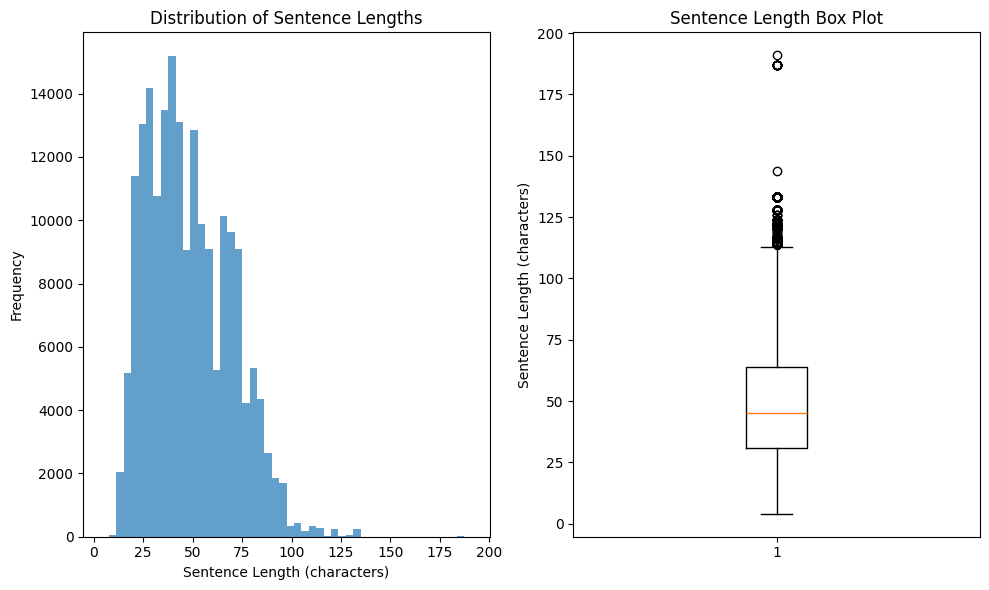

/content/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3: Valid
/content/common_voice/cv-valid-train/cv-valid-train/sample-000001.mp3: Valid
/content/common_voice/cv-valid-train/cv-valid-train/sample-000002.mp3: Valid
/content/common_voice/cv-valid-train/cv-valid-train/sample-000003.mp3: Valid
/content/common_voice/cv-valid-train/cv-valid-train/sample-000004.mp3: Valid


In [21]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Paths
CSV_PATH = "/content/common_voice/cv-valid-train.csv"

AUDIO_DIR = "/content/common_voice/cv-valid-train"


# Load CSV
df = pd.read_csv(CSV_PATH)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nDataset statistics:")
print(f"Total samples: {len(df)}")
print(f"Unique sentences: {df['text'].nunique()}")

# Sentence length stats
df['sentence_length'] = df['text'].str.len()
print("Sentence length stats:")
print(df['sentence_length'].describe())

# Visualize sentence length
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['sentence_length'], bins=50, alpha=0.7)
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(df['sentence_length'])
plt.ylabel('Sentence Length (characters)')
plt.title('Sentence Length Box Plot')
plt.tight_layout()
plt.show()


# Ensure paths are correct: strip leading folder if needed
def get_audio_path(filename):
    path = Path(filename)
    if not (AUDIO_DIR / path).exists():
        # sometimes CSV has folder prefix, remove it
        path = path.name
    return AUDIO_DIR / path

sample_files = df['filename'].head().tolist()
for file in sample_files:
    full_path = get_audio_path(file)
    exists = full_path.exists()
    print(f"{full_path}: {'Valid' if exists else 'Missing'}")


In [23]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters but keep letters, spaces, and apostrophes
    text = re.sub(r"[^a-z\s']", "", text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text cleaning
df['cleaned_sentence'] = df['text'].apply(clean_text)

# Show examples of cleaning
print("Text cleaning examples:")
for i in range(5):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_sentence'].iloc[i]}")
    print("-" * 50)

# Create vocabulary from cleaned text
all_text = " ".join(df['cleaned_sentence'].tolist())
vocab_chars = set(all_text)
vocab_list = sorted(list(vocab_chars))

print(f"Vocabulary size: {len(vocab_list)}")
print(f"Characters: {vocab_list}")

# Create tokenizer vocabulary dict
vocab_dict = {char: idx for idx, char in enumerate(vocab_list)}
# Add special tokens
vocab_dict['[UNK]'] = len(vocab_dict)
vocab_dict['[PAD]'] = len(vocab_dict)

print(f"\nFinal vocabulary size with special tokens: {len(vocab_dict)}")
print("Special tokens added: [UNK], [PAD]")

# Save vocabulary for tokenizer
import json
vocab_path = "/content/vocab.json"
with open(vocab_path, 'w') as f:
    json.dump(vocab_dict, f)


Text cleaning examples:
Original: learn to recognize omens and follow them the old king had said
Cleaned:  learn to recognize omens and follow them the old king had said
--------------------------------------------------
Original: everything in the universe evolved he said
Cleaned:  everything in the universe evolved he said
--------------------------------------------------
Original: you came so that you could learn about your dreams said the old woman
Cleaned:  you came so that you could learn about your dreams said the old woman
--------------------------------------------------
Original: so now i fear nothing because it was those omens that brought you to me
Cleaned:  so now i fear nothing because it was those omens that brought you to me
--------------------------------------------------
Original: if you start your emails with greetings let me be the first to welcome you to earth
Cleaned:  if you start your emails with greetings let me be the first to welcome you to earth
--------

In [24]:
# Create tokenizer from our vocabulary
tokenizer = Wav2Vec2CTCTokenizer(
    vocab_path,
    unk_token="[UNK]",
    pad_token="[PAD]",
    word_delimiter_token="|"
)

# Feature extractor for audio preprocessing
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True
)

# Combine tokenizer and feature extractor
processor = Wav2Vec2Processor(
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)


# Load pre-trained Wav2Vec2 model
model_name = "facebook/wav2vec2-large-960h"

model = Wav2Vec2ForCTC.from_pretrained(
    model_name,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

# Move model to device
model = model.to(device)
print(f"Model moved to: {device}")

# Print model information
print(f"\nModel configuration:")
print(f"- Vocab size: {model.config.vocab_size}")
print(f"- Hidden size: {model.config.hidden_size}")
print(f"- Number of attention heads: {model.config.num_attention_heads}")
print(f"- Number of hidden layers: {model.config.num_hidden_layers}")

model.freeze_feature_encoder()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to: cuda

Model configuration:
- Vocab size: 32
- Hidden size: 1024
- Number of attention heads: 16
- Number of hidden layers: 24


In [20]:
path_column = "filename"  # column in CSV containing audio filenames
df = df[df['cleaned_sentence'].notna() & df['cleaned_sentence'].str.strip().astype(bool)]

def load_and_preprocess_audio(audio_path, target_sr=16000):
    try:
        # Load audio
        speech, sr = librosa.load(audio_path, sr=target_sr, mono=True)
        return speech
    except Exception as e:
        return None

def prepare_dataset(batch):
    # Load audio
    audio_path = Path(AUDIO_DIR) / batch[path_column]
    speech = load_and_preprocess_audio(str(audio_path))

    if speech is None:
        return None

    # Process audio
    batch["input_values"] = processor(speech, sampling_rate=16000).input_values[0]

    # Ensure text is string and non-empty
    text = batch.get("cleaned_sentence", "")
    if text is None or not isinstance(text, str):
        text = str(text) if text is not None else ""
    text = text.strip()

    if len(text) == 0:
        return None

    # Tokenize text
    with processor.as_target_processor():
        batch["labels"] = processor(text, truncation=True).input_ids

    return batch

# Prepare train-validation split (70-30)
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=None
)


# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# Process a small sample first to test
sample_size = 5
train_sample = train_dataset.select(range(sample_size))

# Process the sample
processed_sample = train_sample.map(
    prepare_dataset,
    remove_columns=train_sample.column_names,
    num_proc=1
)

# Filter out None values
processed_sample = processed_sample.filter(lambda x: x is not None)

Splitting dataset (70% train, 30% validation)...
Training samples: 137043
Validation samples: 58733
Datasets created!

Testing data processing on small sample...


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).